In [1]:
import os
import pathlib
import hashlib
import datetime
import json
import itertools

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import decoupler
import requests
import seaborn as sns
import scipy
import statsmodels.stats.multitest

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/scvi_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.options.display.max_rows = 300

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
FONT_DIR = '/projects/b1038/Pulmonary/nmarkov/fonts'
for f in os.listdir(FONT_DIR):
    if f.endswith('.ttf'):
        mpl.font_manager.fontManager.addfont(f'{FONT_DIR}/{f}')

In [5]:
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["pdf.fonttype"] = 42
# plt.rcParams['figure.constrained_layout.use'] = False
# mpl.rcParams['mathtext.default'] = 'regular'

In [6]:
def sanitize_name(name):
    return name.replace(' ', '_').replace('*', '').replace(';', '_and').replace('/', '_')

In [7]:
msigdb = decoupler.get_resource('MSigDB', organism='human')
hallmark = msigdb[msigdb.collection.eq('hallmark')]
hallmark = hallmark[~hallmark.duplicated(['geneset', 'genesymbol'])]

**NB!** some genes have new names in HALLMARK

In [8]:
hallmark.genesymbol.eq('SEPP1').sum()

0

In [9]:
hallmark.genesymbol.eq('SELENOP').sum()

2

In [10]:
PF_GENESET_URL = (
    'https://maayanlab.cloud/Harmonizome/api/1.0/gene_set/'
    'pulmonary+fibrosis/DISEASES+Text-mining+Gene-Disease+Assocation+Evidence+Scores'
)
PF_GENESET_FILE = 'Harmonizome_PF_set.json'
PF_GENESET_SHA1 = '3f3dd4f618e335382982d16e0afae9f2240dcbd6'

In [11]:
if not os.path.exists(PF_GENESET_FILE):
    with open(PF_GENESET_FILE, 'w') as f:
        contents = requests.get(PF_GENESET_URL).text
        f.write(contents)
        print(f'Downloaded PF geneset with sha1 {hashlib.sha1(contents.encode()).hexdigest()}')
contents = open(PF_GENESET_FILE).read()
if hashlib.sha1(contents.encode()).hexdigest() != PF_GENESET_SHA1:
    print('SHA1 of PF gene set does not match the stored one')
pf_genes = json.loads(contents)
pf_genes = [x['gene']['symbol'] for x in pf_genes['associations']]

In [12]:
hallmark = pd.concat([
    hallmark,
    pd.DataFrame(dict(genesymbol=pf_genes, collection='Harmonizome', geneset='Harmonizome_PF'))
])

In [13]:
DATA = pathlib.Path('../../data/31_bal-object/')

In [14]:
BASE = DATA / 'pseudobulk-gsva'

In [15]:
clinical_data = pd.read_csv('../00clinical-v2.csv')

In [17]:
samples = pd.read_csv("../00all-samples.csv")

In [18]:
clinical_data = clinical_data.merge(
    samples[['Sample', 'External Sample ID']],
    left_on='study_code',
    right_on='Sample',
    how='left'
)

In [19]:
clinical_data['mmf'] = clinical_data.patient_on_mmf.map(
    {True: 'MMF', False: 'Naive'}
)

In [20]:
%%time
data = {}
for ct in sorted(os.listdir(BASE)):
    if not (BASE / ct / 'data' / 'transformed.tsv').exists():
        print(f'{ct} does not have counts')
        continue
    pseudobulk = pd.read_table(BASE / ct / 'data' / 'transformed.tsv', delim_whitespace=True).T
    metadata = pd.read_csv(BASE / ct / 'data' / f'{ct}-meta.csv', index_col=0)
    metadata.index = metadata.index.str.replace(r'\_[ATCG]+$', '', regex=True)
    metadata = metadata.merge(
        clinical_data[['External Sample ID', 'fvc_pred', 'mmf']],
        on='External Sample ID',
        how='left'
    )
    # Copy value for SSc8 from SSc6 (repeat sample)
    metadata.loc[metadata['External Sample ID'].eq('SSc_SSc8'), 'mmf'] = 'Naive'
    data[ct] = {
        'expr': pseudobulk,
        'meta': metadata
    }

.DS_Store does not have counts
._.DS_Store does not have counts
Activated_monocytes does not have counts
Ciliated_cells does not have counts
Mast_cells does not have counts
Proliferating_T_cells does not have counts
Secretory_cells does not have counts
pDC does not have counts
CPU times: user 1.32 s, sys: 41 ms, total: 1.36 s
Wall time: 2.14 s


In [21]:
data = {
    k.replace('_', ' ')\
        .replace('MoAM-3 mature', 'MoAM-2')\
        .replace('MoAM-4', 'MoAM-3')\
        .replace('gd NKT', 'NK + γδT',)
        .replace('Perivascular', 'Interstitial'): v
    for k, v in data.items()
}

In [22]:
data.keys()

dict_keys(['B cells', 'CCR7+ DC', 'CD4 TEM cells', 'CD4 naive T cells', 'CD8 TEM cells', 'CD8 TRM cells', 'DC1', 'DC2', 'MoAM-1', 'MoAM-2', 'MoAM-3 profibrotic', 'Monocytes', 'Interstitial macrophages', 'Proliferating macrophages', 'TRAM-1', 'TRAM-2', 'TRAM-3', 'TRAM-4', 'TRAM-5 MT1G', 'TRAM-6 activated', 'Tregs', 'NK + γδT cells', 'global'])

# 1. Plot _IFNG_ expression in T cells

In [ ]:
t_cells = [
    'CD4 TEM cells', 'CD4 naive T cells', 'CD8 TEM cells', 'CD8 TRM cells',
    'Tregs', 'NK + γδT cells'
]

In [25]:
ifng_expr = []
for cl in t_cells:
    m = data[cl]['meta'].set_index('External Sample ID')
    for i, val in data[cl]['expr']['IFNG'].items():
        ifng_expr.append((cl, i, val, m.Status[i], m.mmf[i]))
ifng_expr = pd.DataFrame(ifng_expr, columns=['cell_type', 'Sample', 'IFNG', 'Status', 'MMF'])

Text(0.5, 1.0, '$IFNG$ expression in T cells')

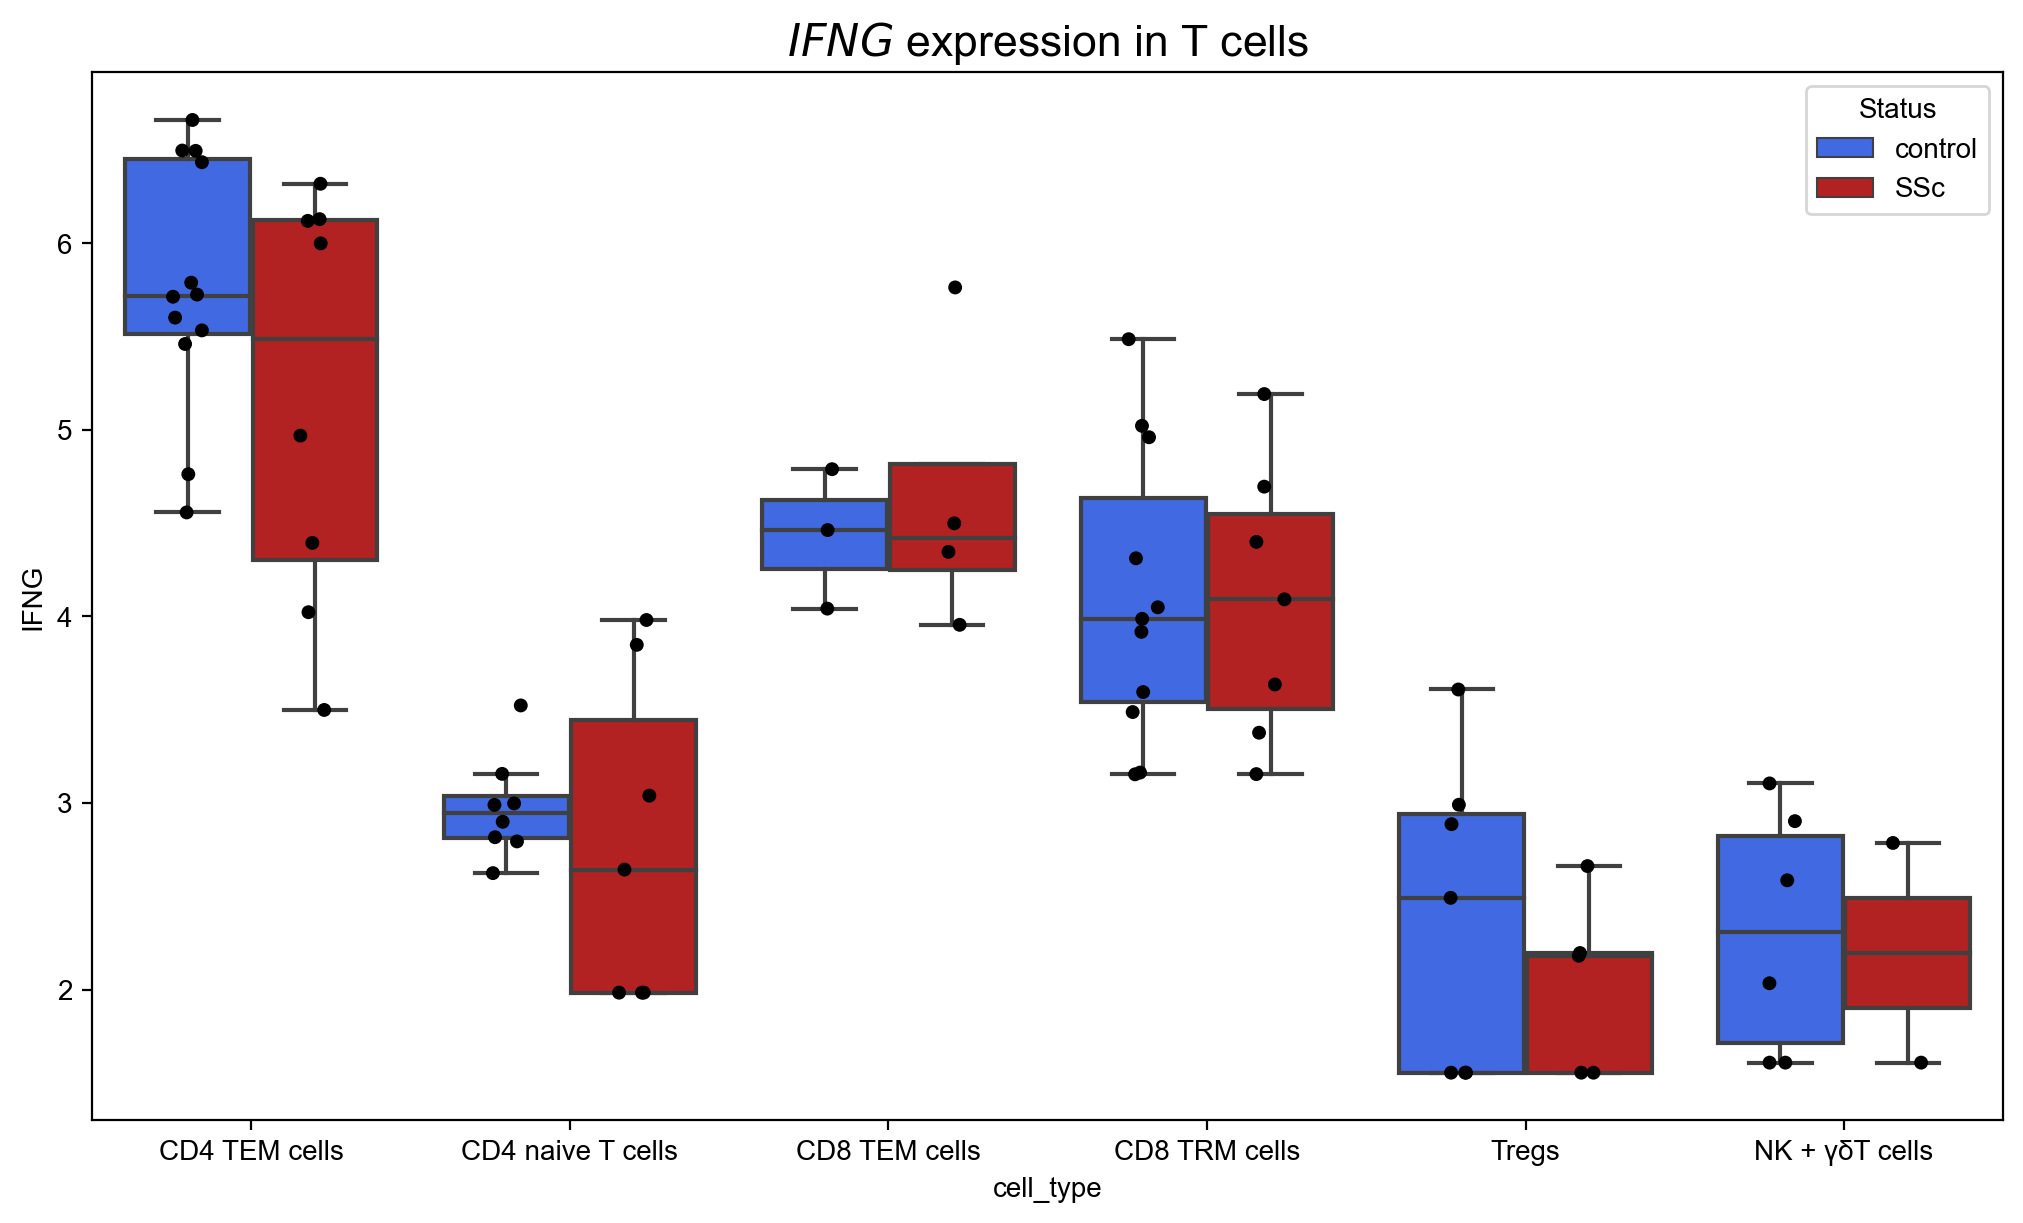

In [26]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
sns.boxplot(
    data=ifng_expr,
    x='cell_type',
    y='IFNG',
    hue='Status',
    palette=['royalblue', 'firebrick'],
    saturation=1,
    ax=ax,
    showfliers=False
)
sns.stripplot(
    data=ifng_expr,
    x='cell_type',
    y='IFNG',
    hue='Status',
    palette=['k', 'k'],
    dodge=True,
    ax=ax,
    legend=False
)
ax.set_title('$IFNG$ expression in T cells', size=16)

Now with stats and only in our T cells

In [27]:
CELL_TYPES = [
    'CD4 TEM cells',
    'CD8 TEM cells',
    'CD8 TRM cells',
]

In [28]:
ifng_expr = ifng_expr.loc[ifng_expr.cell_type.isin(CELL_TYPES)].copy()
ifng_expr.cell_type = pd.Categorical(ifng_expr.cell_type, categories=CELL_TYPES)

In [29]:
ifng_expr.head()

,cell_type,Sample,IFNG,Status,MMF
0,CD4 TEM cells,SSc_C1,5.713063,control,NaN
1,CD4 TEM cells,SSc_C2,5.459890,control,NaN
2,CD4 TEM cells,SSc_C3,6.434110,control,NaN
3,CD4 TEM cells,SSc_SSc4,6.128962,SSc,Naive
4,CD4 TEM cells,SSc_C5,5.788489,control,NaN


In [30]:
stat_results = []
for ct in ifng_expr.cell_type.unique():
    ctrl = ifng_expr.IFNG[ifng_expr.cell_type.eq(ct) & ifng_expr.Status.eq('control')]
    ssc = ifng_expr.IFNG[ifng_expr.cell_type.eq(ct) & ifng_expr.Status.eq('SSc')]
    if ctrl.size == 0 or ssc.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(ctrl, ssc).pvalue
    stat_results.append(["cell_type", ct, "Control", "SSc-ILD", ctrl.size, ssc.size, pval])
stat_results = pd.DataFrame(stat_results, columns=["variable", "value", "group1", "group2",
                                                   "group1_size", "group2_size", "pval"])

stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]

pairs = []
for _, r in stat_results_sign.iterrows():
    if r.variable == "cell_type":
        pairs.append(((r.value, r.group1), (r.value, r.group2)))
    else:
        pairs.append(((r.group1, r.value), (r.group2, r.value)))
pairs

[]

In [31]:
stat_results

,variable,value,group1,group2,group1_size,group2_size,pval,pval_adj
0,cell_type,CD4 TEM cells,Control,SSc-ILD,12,8,0.305390,0.916171
1,cell_type,CD8 TEM cells,Control,SSc-ILD,3,4,1.000000,1.000000
2,cell_type,CD8 TRM cells,Control,SSc-ILD,11,7,0.929801,1.000000


No significant differences using Mann-Whitney with FDR

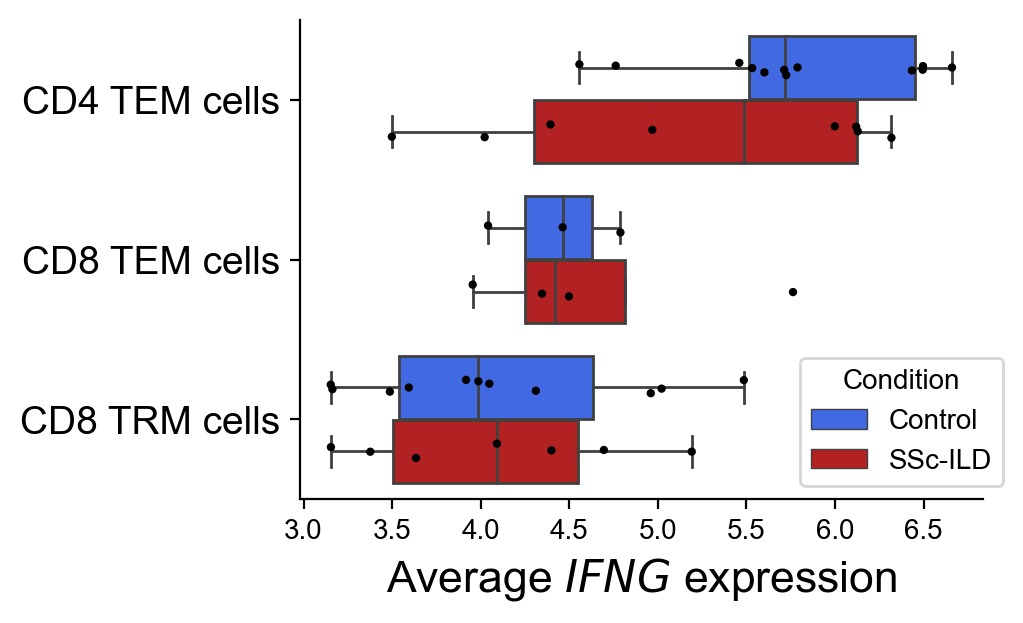

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3), constrained_layout=True)

sns.boxplot(
    data=ifng_expr,
    y='cell_type',
    x='IFNG',
    hue='Status',
    palette=['royalblue', 'firebrick'],
    ax=ax,
    showfliers=False,
    saturation=1,
    linewidth=1
)
sns.stripplot(
    data=ifng_expr,
    y='cell_type',
    x='IFNG',
    hue='Status',
    dodge=True,
    ax=ax,
    size=3,
    palette=['k', 'k'],
    legend=False
)

# # start_height = counts[pc].max()
# incrementer = 20 # px
# labels = [x.get_text() for x in ax.get_yticklabels()]
# q = ax.transData.inverted().transform([[0, 0], [incrementer, 0]])
# x_offset = q[1][0] - q[0][0]
# gap = x_offset / 2
# # y = start_height
# for _, r in stat_results_sign.iterrows():
#     p = f'$q={r.pval_adj:.3f}$'
#     y = labels.index(str(r.value))
#     x = counts.percent_in_sample[counts.cell_type_level_3.eq(r.value)].max()

#     col = 'k'
#     h = gap / 2
#     x += gap
#     o = 0.3

#     bracket = ax.plot([x, x+h, x+h, x], [y-o, y-o, y+o, y+o], lw=1, c=col)
#     txt = ax.text(x+2*h, y, p, ha='left', va='center', color=col, size=8)

ax.set_xlabel('Average $IFNG$ expression', size=16)
ax.set_ylabel('')
ax.tick_params(axis='y', labelsize=14)
ax.spines[['top', 'right']].set_visible(False)
h, l = ax.get_legend_handles_labels()
ax.legend(
    handles=h,
    labels=['Control', 'SSc-ILD'],
    title='Condition',
    bbox_to_anchor=(1.05, 0),
    loc='lower right'
    # fontsize=12,
    # title_fontsize=12
)
fig.savefig('00_figures/Figure_2F_avg_IFNG_expr.pdf')

In [33]:
ifng_expr['Status_MMF'] = ifng_expr.Status + '_' + ifng_expr.MMF
ifng_expr.Status_MMF = ifng_expr.Status_MMF.fillna('control')

Text(0.5, 1.0, '$IFNG$ expression in T cells')

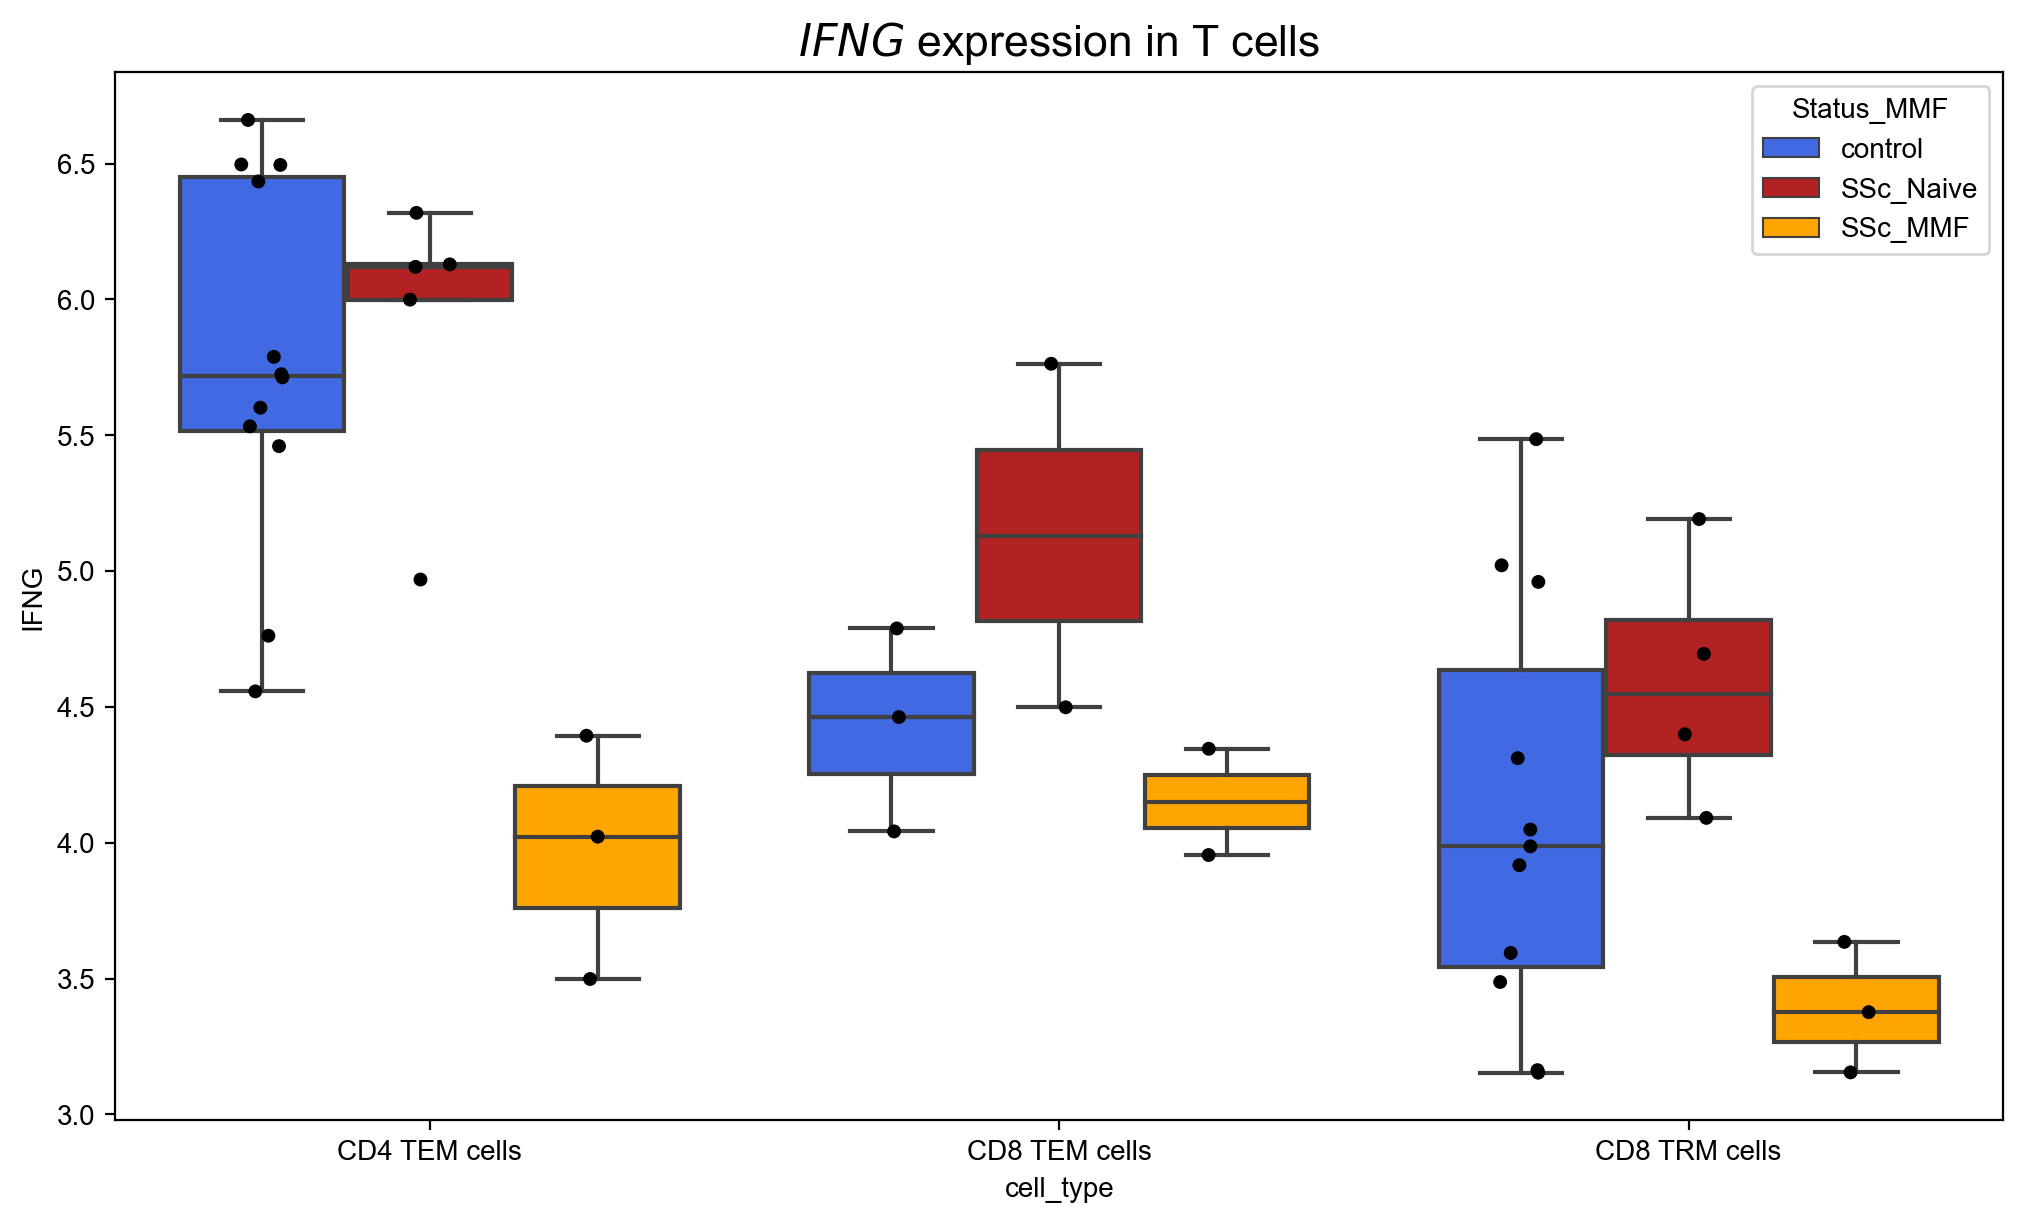

In [34]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
sns.boxplot(
    data=ifng_expr,
    x='cell_type',
    y='IFNG',
    hue='Status_MMF',
    palette=['royalblue', 'firebrick', 'orange'],
    saturation=1,
    ax=ax,
    showfliers=False
)
sns.stripplot(
    data=ifng_expr,
    x='cell_type',
    y='IFNG',
    hue='Status_MMF',
    palette=['k', 'k', 'k'],
    dodge=True,
    ax=ax,
    legend=False
)
ax.set_title('$IFNG$ expression in T cells', size=16)

# 2. Plot CSF genes

In [23]:
data.keys()

dict_keys(['B cells', 'CCR7+ DC', 'CD4 TEM cells', 'CD4 naive T cells', 'CD8 TEM cells', 'CD8 TRM cells', 'DC1', 'DC2', 'MoAM-1', 'MoAM-2', 'MoAM-3 profibrotic', 'Monocytes', 'Interstitial macrophages', 'Proliferating macrophages', 'TRAM-1', 'TRAM-2', 'TRAM-3', 'TRAM-4', 'TRAM-5 MT1G', 'TRAM-6 activated', 'Tregs', 'NK + γδT cells', 'global'])

In [24]:
macs = [
    'Monocytes', 'MoAM-1', 'MoAM-2', 'MoAM-3 profibrotic', 'Interstitial macrophages',
    'TRAM-1', 'TRAM-2', 'TRAM-3', 'TRAM-4', 'TRAM-5 MT1G', 'TRAM-6 activated'
]

In [25]:
genes = [
    'CSF1', 'CSF2', 'CSF1R', 'CSF2RA', 'CSF2RB'
]

In [26]:
csf_expr = []
for cl in macs:
    m = data[cl]['meta'].set_index('External Sample ID')
    for gene in genes:
        for i, val in data[cl]['expr'][gene].items():
            csf_expr.append((cl, i, gene, val, m.Status[i], m.mmf[i]))
csf_expr = pd.DataFrame(csf_expr, columns=['cell_type', 'Sample', 'gene', 'expr', 'Status', 'MMF'])

In [27]:
csf_expr['exp_group'] = 'Control'
csf_expr.loc[csf_expr.MMF.eq('Naive'), 'exp_group'] = 'SSc-ILD (no myco)'
csf_expr.loc[csf_expr.MMF.eq('MMF'), 'exp_group'] = 'SSc-ILD (current myco)'
csf_expr.exp_group = pd.Categorical(csf_expr.exp_group, categories=[
    'Control', 'SSc-ILD (no myco)', 'SSc-ILD (current myco)'
])

In [ ]:
def plot_gene_with_stats(data, gene):
    data_subset = data.loc[data.gene.eq(gene)]
    fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
    sns.boxplot(
        data=data_subset,
        y='cell_type',
        x='expr',
        hue='exp_group',
        palette=['royalblue', 'firebrick', 'orange'],
        ax=ax,
        showfliers=False,
        saturation=1,
        linewidth=1
    )
    sns.stripplot(
        data=data_subset,
        y='cell_type',
        x='expr',
        hue='exp_group',
        dodge=True,
        ax=ax,
        size=3,
        palette=['k', 'k', 'k'],
        legend=False
    )
    exp_groups = list(data_subset.exp_group.cat.categories)
    stat_results = []
    for ct in data_subset.cell_type.unique():
        for g1, g2 in itertools.combinations(exp_groups, 2):
            g1_data = data_subset.expr[
                data_subset.cell_type.eq(ct)
                & data_subset.exp_group.eq(g1)
            ]
            g2_data = data_subset.expr[
                data_subset.cell_type.eq(ct)
                & data_subset.exp_group.eq(g2)
            ]
            if g1_data.size == 0 or g2_data.size == 0:
                continue
            pval = scipy.stats.mannwhitneyu(g1_data, g2_data).pvalue
            stat_results.append(["cell_type", ct, g1, g2, g1_data.size, g2_data.size, pval])
    stat_results = pd.DataFrame(stat_results, columns=["variable", "value", "group1", "group2",
                                                       "group1_size", "group2_size", "pval"])

    stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]
    stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]

    if stat_results_sign.shape[0] > 0:
        start_height = data_subset.expr.max()
        incrementer = 20 # px
        labels = [x.get_text() for x in ax.get_yticklabels()]
        q = ax.transData.inverted().transform([[0, 0], [incrementer, 0]])
        x_offset = q[1][0] - q[0][0]
        gap = x_offset / 2
        # y = start_height
        for _, r in stat_results_sign.iterrows():
            p = f'$q={r.pval_adj:.3f}$'
            y = labels.index(str(r.value))
            x = data_subset.expr[data_subset.cell_type.eq(r.value)].max()
            g1_idx = exp_groups.index(r.group1)
            g2_idx = exp_groups.index(r.group2)
            y1 = y + 0.3 * (g1_idx - 1)
            y2 = y + 0.3 * (g2_idx - 1)

            col = 'k'
            h = gap / 2
            x += gap

            bracket = ax.plot([x, x+h, x+h, x], [y1, y1, y2, y2], lw=1, c=col)
            txt = ax.text(x+2*h, y, p, ha='left', va='center', color=col, size=8)

    ax.set_xlabel(f'Average ${gene}$ expression', size=16)
    ax.set_ylabel('')
    ax.tick_params(axis='y', labelsize=14)
    ax.spines[['top', 'right']].set_visible(False)
    h, l = ax.get_legend_handles_labels()
    ax.legend(
        handles=h,
        labels=[l.replace('(', '\n(') for l in exp_groups],
        title='Condition',
        bbox_to_anchor=(0.8, 1),
        loc='upper left'
    )
    return fig, stat_results

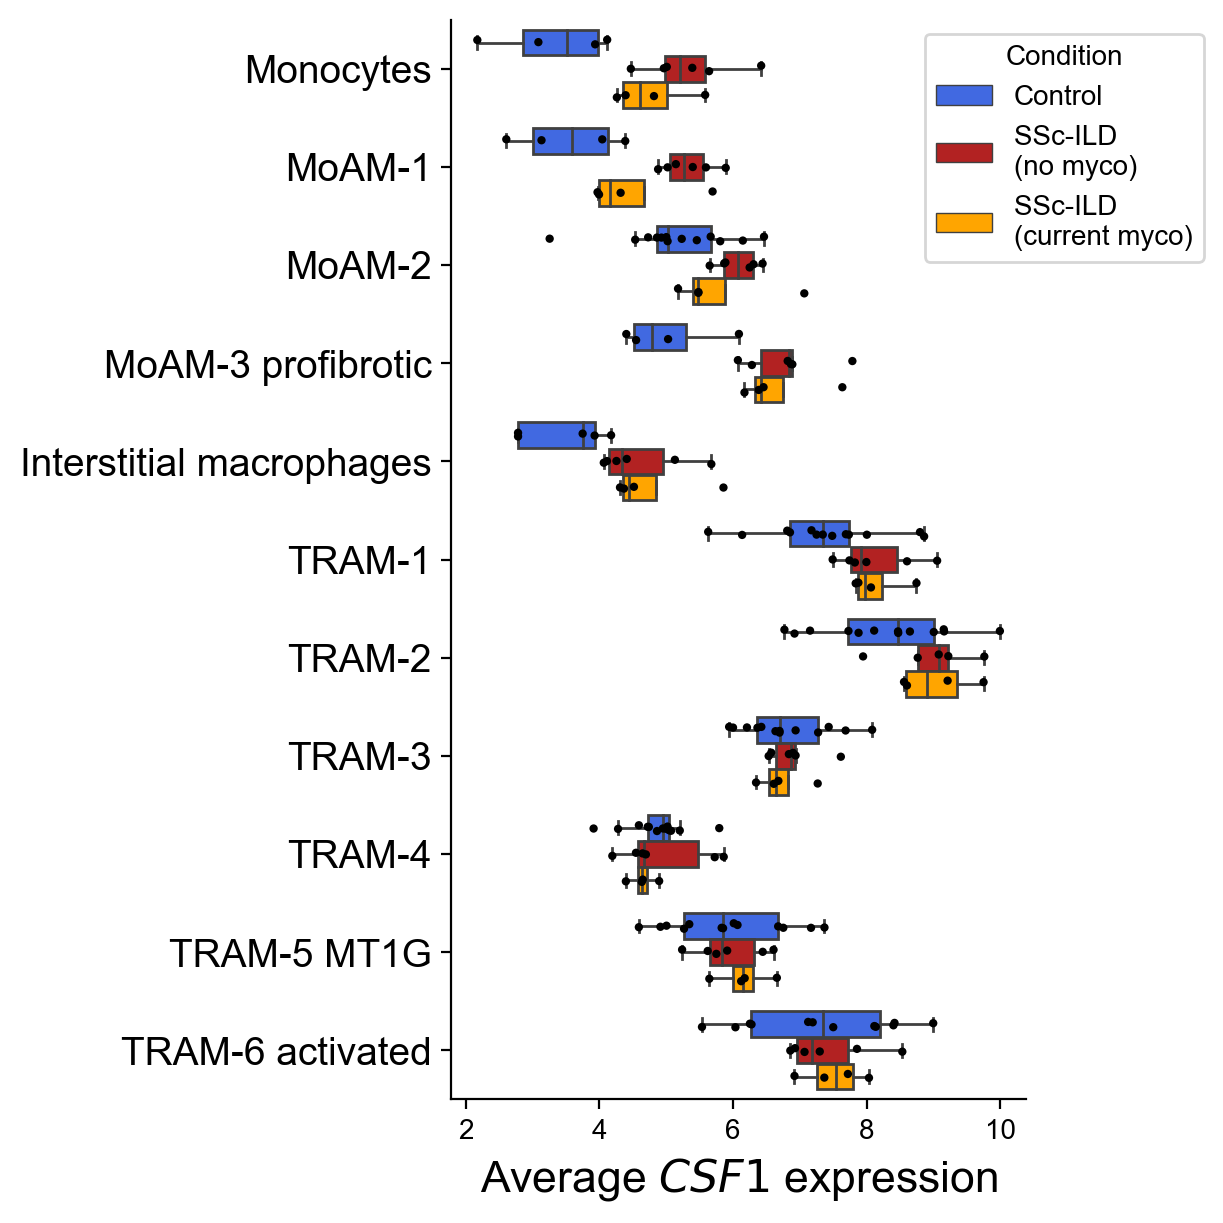

In [41]:
fig, stat_results = plot_gene_with_stats(csf_expr, 'CSF1')

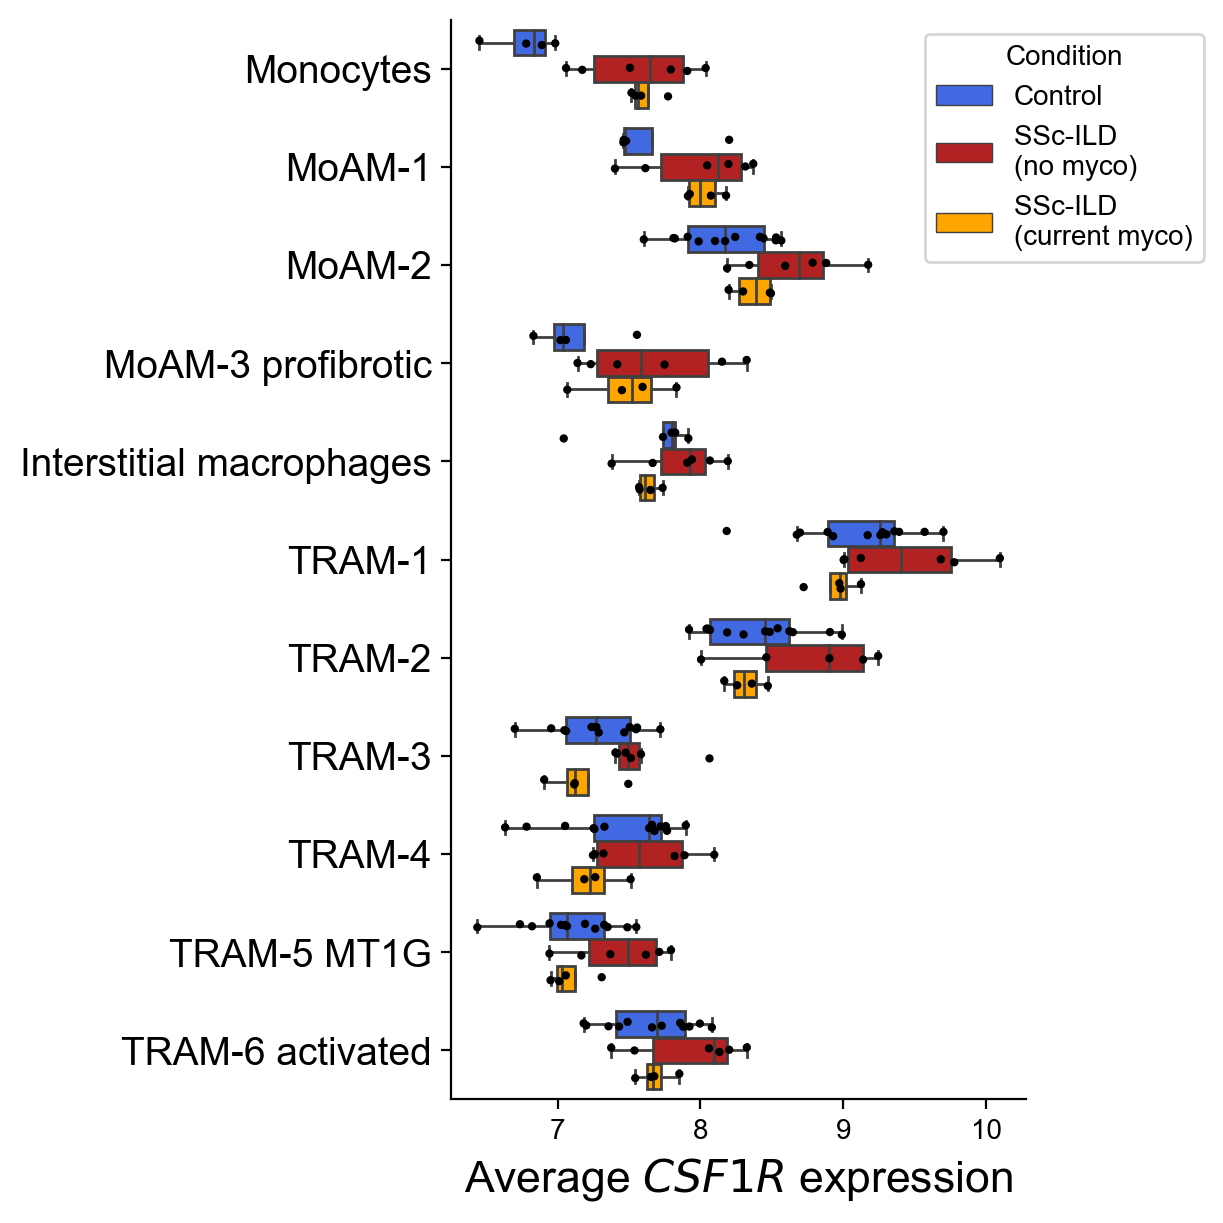

In [42]:
fig, stat_results = plot_gene_with_stats(csf_expr, 'CSF1R')

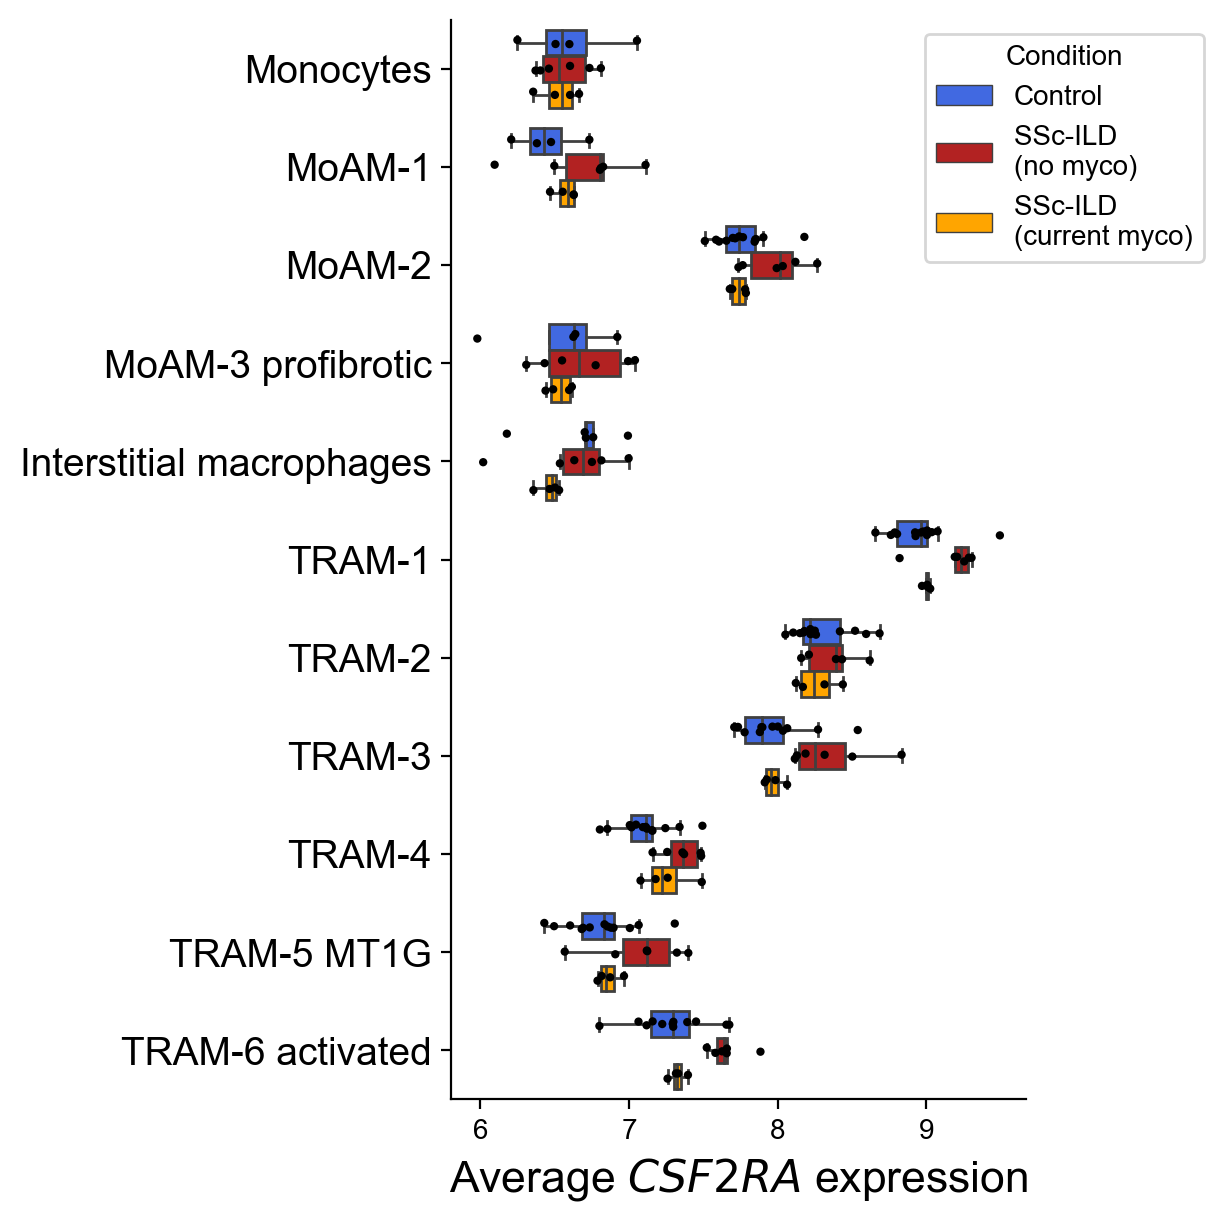

In [43]:
fig, stat_results = plot_gene_with_stats(csf_expr, 'CSF2RA')

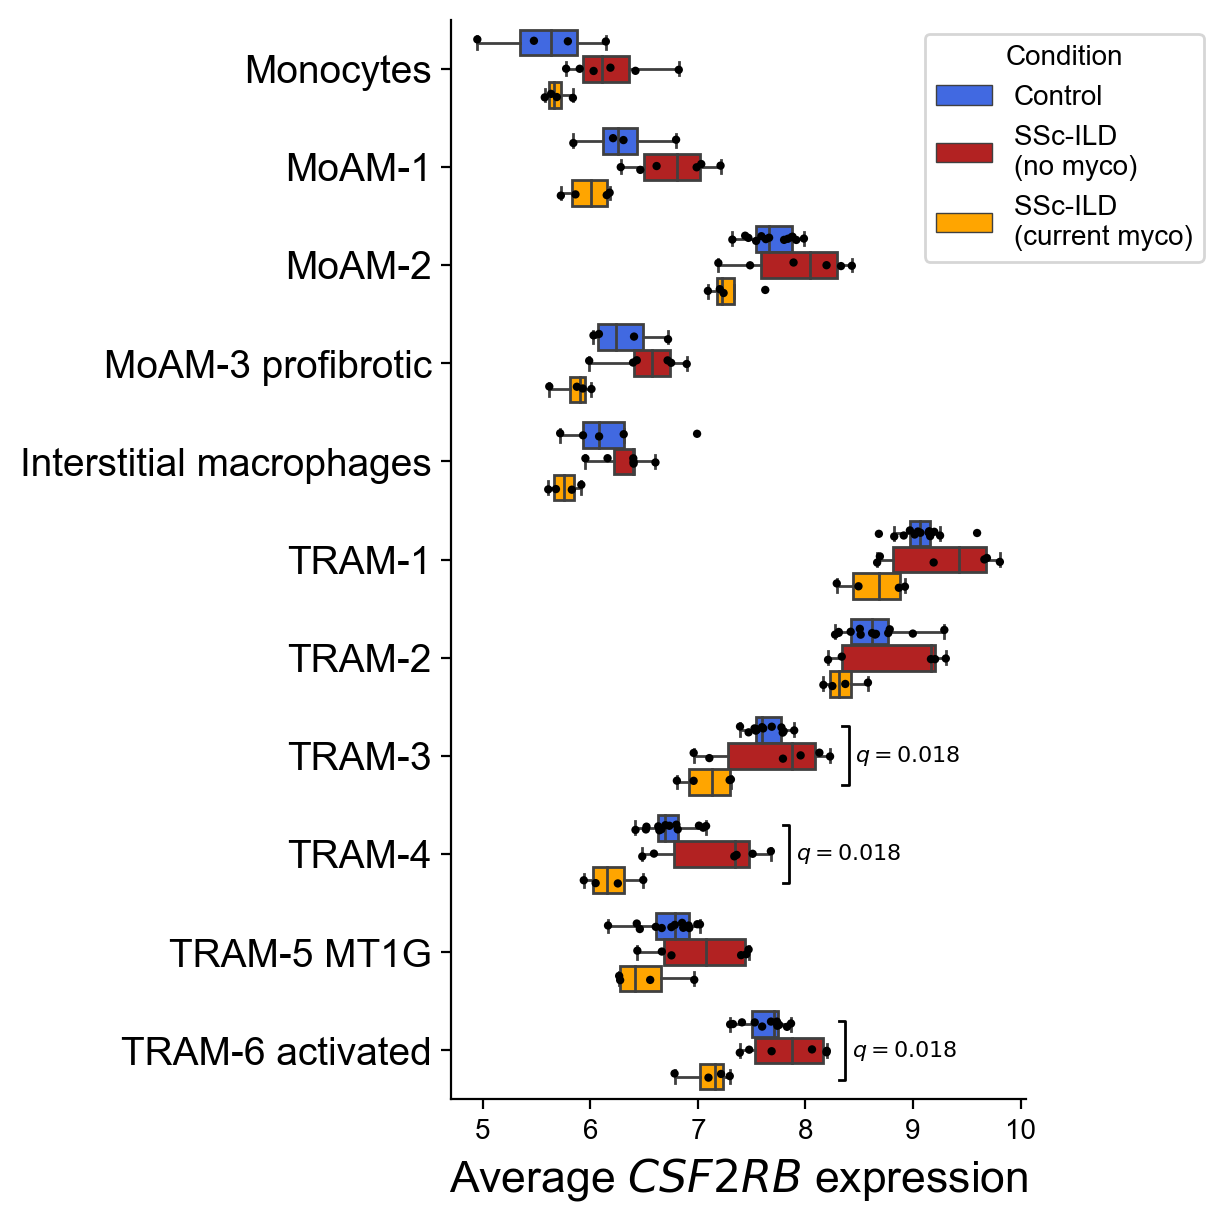

In [44]:
fig, stat_results = plot_gene_with_stats(csf_expr, 'CSF2RB')

In [ ]:
def plot_gene_with_stats_way2(data, gene):
    data_subset = data.loc[data.gene.eq(gene)]
    fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
    sns.boxplot(
        data=data_subset,
        y='cell_type',
        x='expr',
        hue='exp_group',
        palette=['royalblue', 'firebrick', 'orange'],
        ax=ax,
        showfliers=False,
        saturation=1,
        linewidth=1
    )
    sns.stripplot(
        data=data_subset,
        y='cell_type',
        x='expr',
        hue='exp_group',
        dodge=True,
        ax=ax,
        size=3,
        palette=['k', 'k', 'k'],
        legend=False
    )
    exp_groups = list(data_subset.exp_group.cat.categories)
    stat_results = []
    for group in exp_groups:
        for ct1, ct2 in itertools.combinations(data_subset.cell_type.unique(), 2):
            ct1_data = data_subset.expr[
                data_subset.cell_type.eq(ct1)
                & data_subset.exp_group.eq(group)
            ]
            ct2_data = data_subset.expr[
                data_subset.cell_type.eq(ct2)
                & data_subset.exp_group.eq(group)
            ]
            if ct1_data.size == 0 or ct2_data.size == 0:
                continue
            pval = scipy.stats.mannwhitneyu(ct1_data, ct2_data).pvalue
            stat_results.append(["cell_type", group, ct1, ct2, ct1_data.size, ct2_data.size, pval])
    stat_results = pd.DataFrame(stat_results, columns=["variable", "value", "group1", "group2",
                                                       "group1_size", "group2_size", "pval"])

    stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]
    stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]

    if stat_results_sign.shape[0] > 0:
        start_height = data_subset.expr.max()
        incrementer = 20 # px
        labels = [x.get_text() for x in ax.get_yticklabels()]
        q = ax.transData.inverted().transform([[0, 0], [incrementer, 0]])
        x_offset = q[1][0] - q[0][0]
        gap = x_offset / 2
        # y = start_height
        x = data_subset.expr.max()
        for _, r in stat_results_sign.iterrows():
            p = f'$q={r.pval_adj:.3f}$'
            y1 = labels.index(str(r.group1))
            y2 = labels.index(str(r.group2))
            # x = data_subset.expr[data_subset.cell_type.isin([r.group1, r.group2])].max()
            group_idx = exp_groups.index(r.value)
            y1 += 0.3 * (group_idx - 1)
            y2 += 0.3 * (group_idx - 1)

            col = 'k'
            h = gap / 2
            x += gap

            bracket = ax.plot([x, x+h, x+h, x], [y1, y1, y2, y2], lw=1, c=col)
            txt = ax.text(x+2*h, (y1 + y2) / 2, p, ha='left', va='center', color=col, size=8)

    ax.set_xlabel(f'Average ${gene}$ expression', size=16)
    ax.set_ylabel('')
    ax.tick_params(axis='y', labelsize=14)
    ax.spines[['top', 'right']].set_visible(False)
    h, l = ax.get_legend_handles_labels()
    ax.legend(
        handles=h,
        labels=[l.replace('(', '\n(') for l in exp_groups],
        title='Condition',
        bbox_to_anchor=(0.8, 1),
        loc='upper left'
    )
    return fig, stat_results

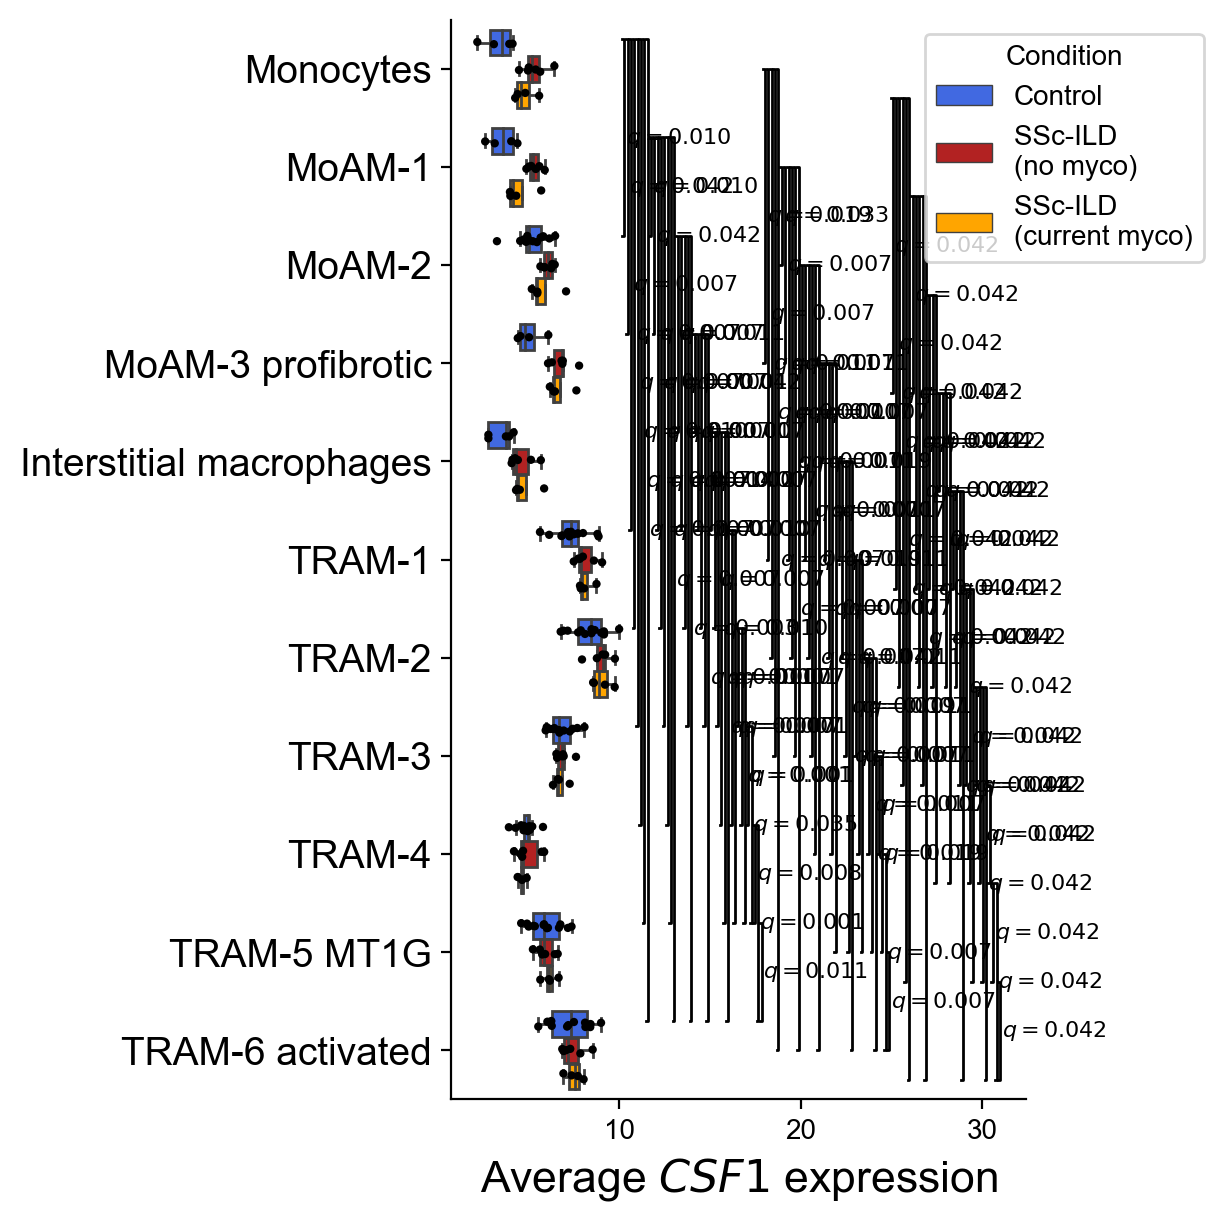

In [56]:
fig, stat_results = plot_gene_with_stats_way2(csf_expr, 'CSF1')

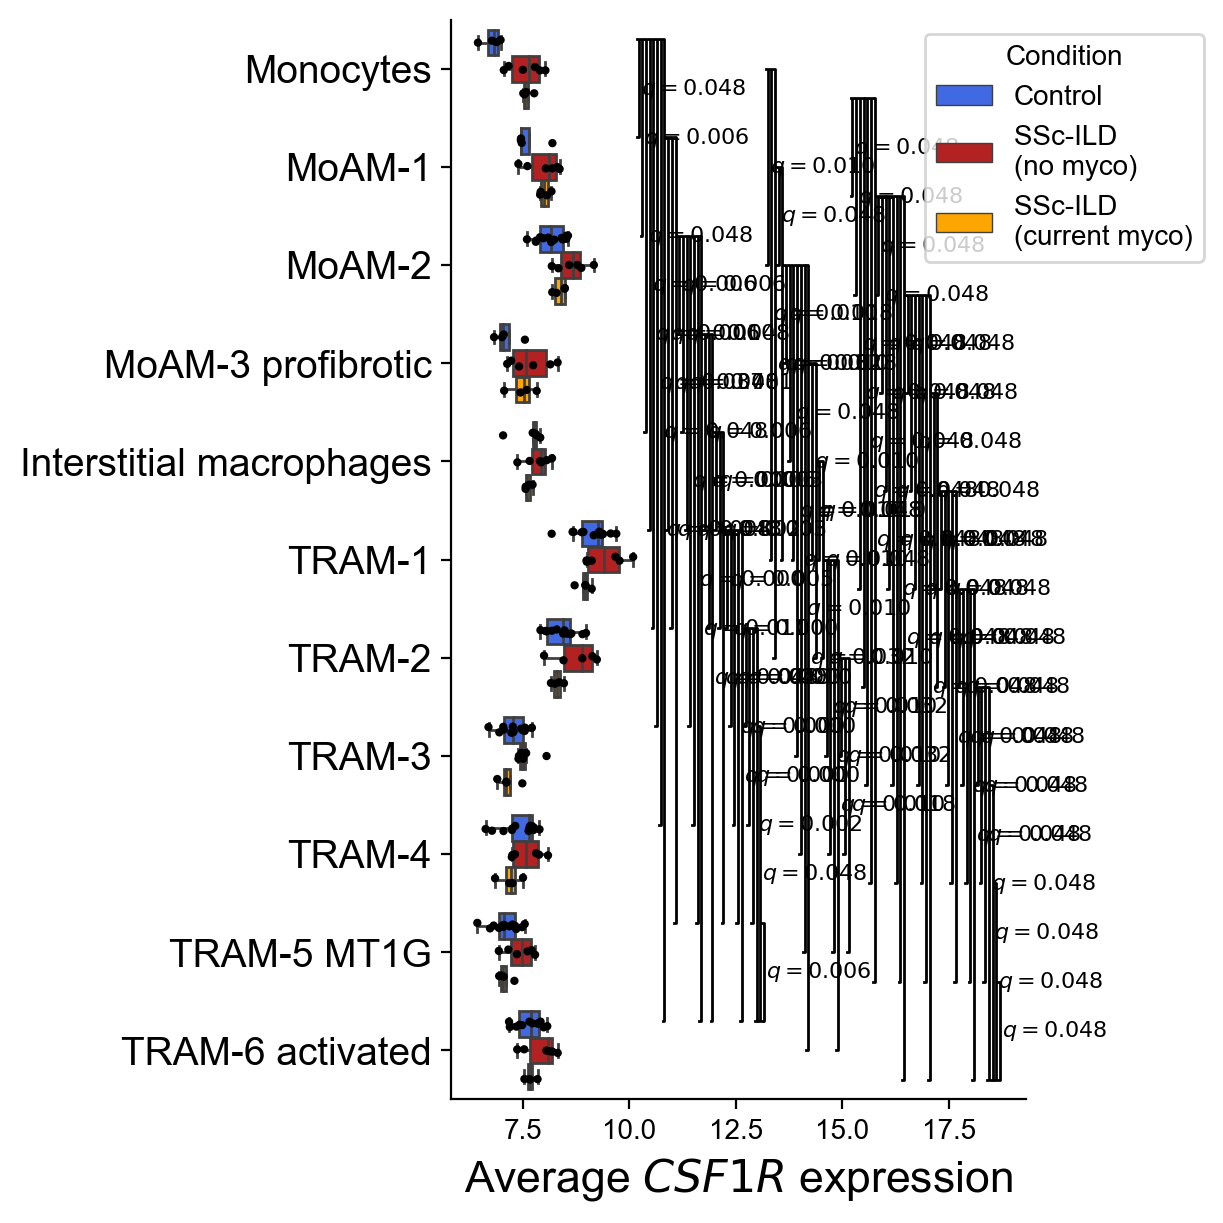

In [59]:
fig, stat_results = plot_gene_with_stats_way2(csf_expr, 'CSF1R')

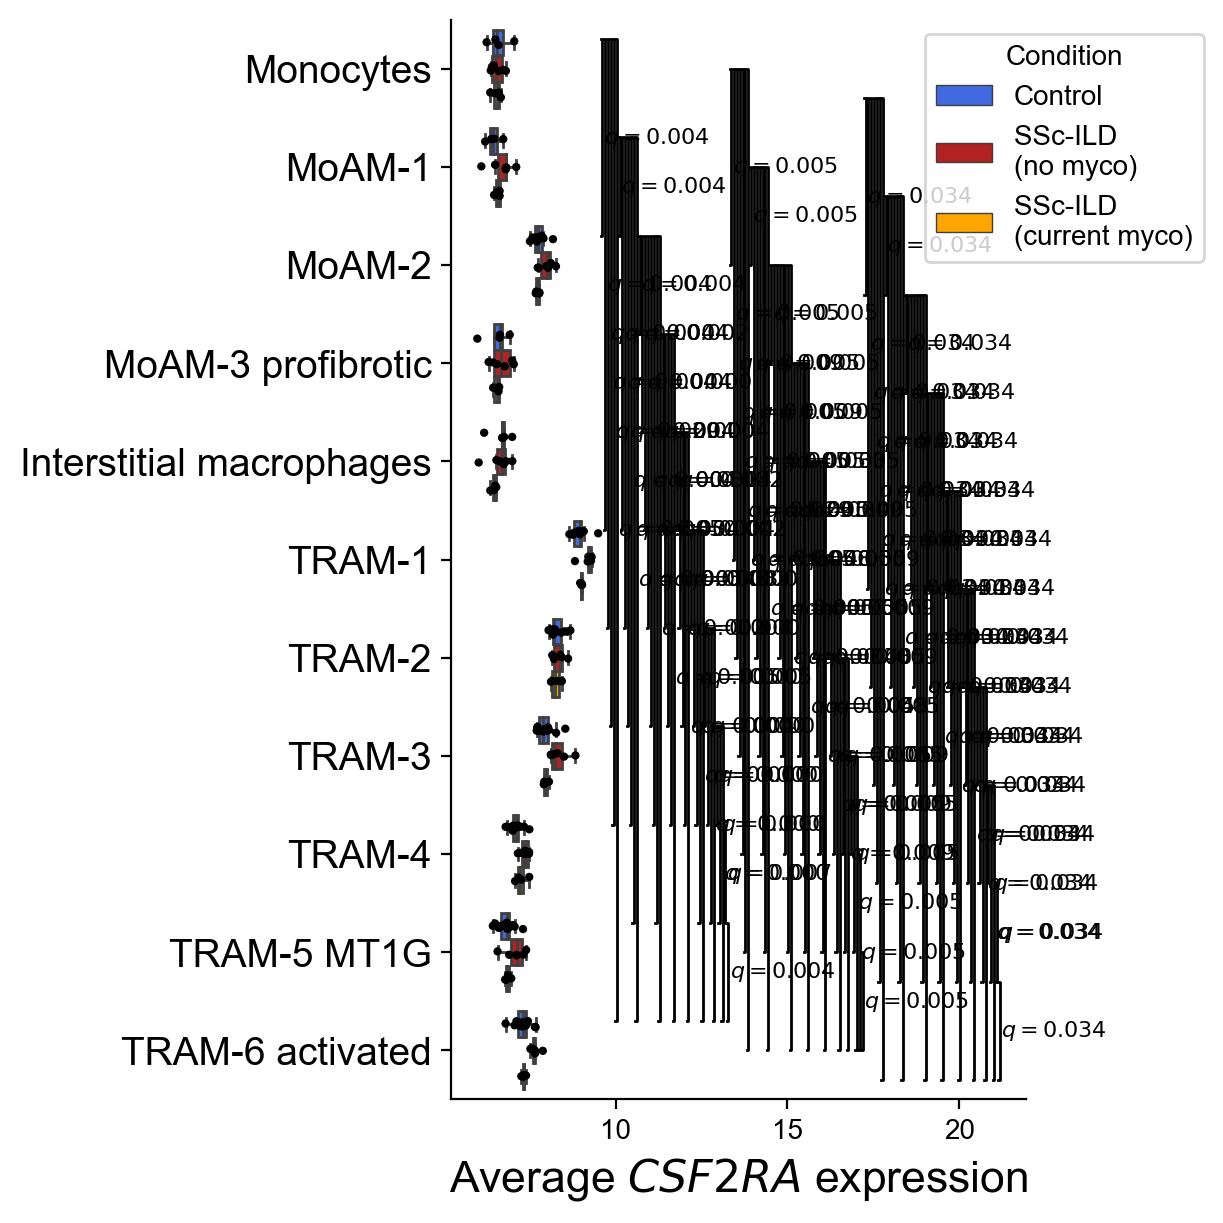

In [60]:
fig, stat_results = plot_gene_with_stats_way2(csf_expr, 'CSF2RA')

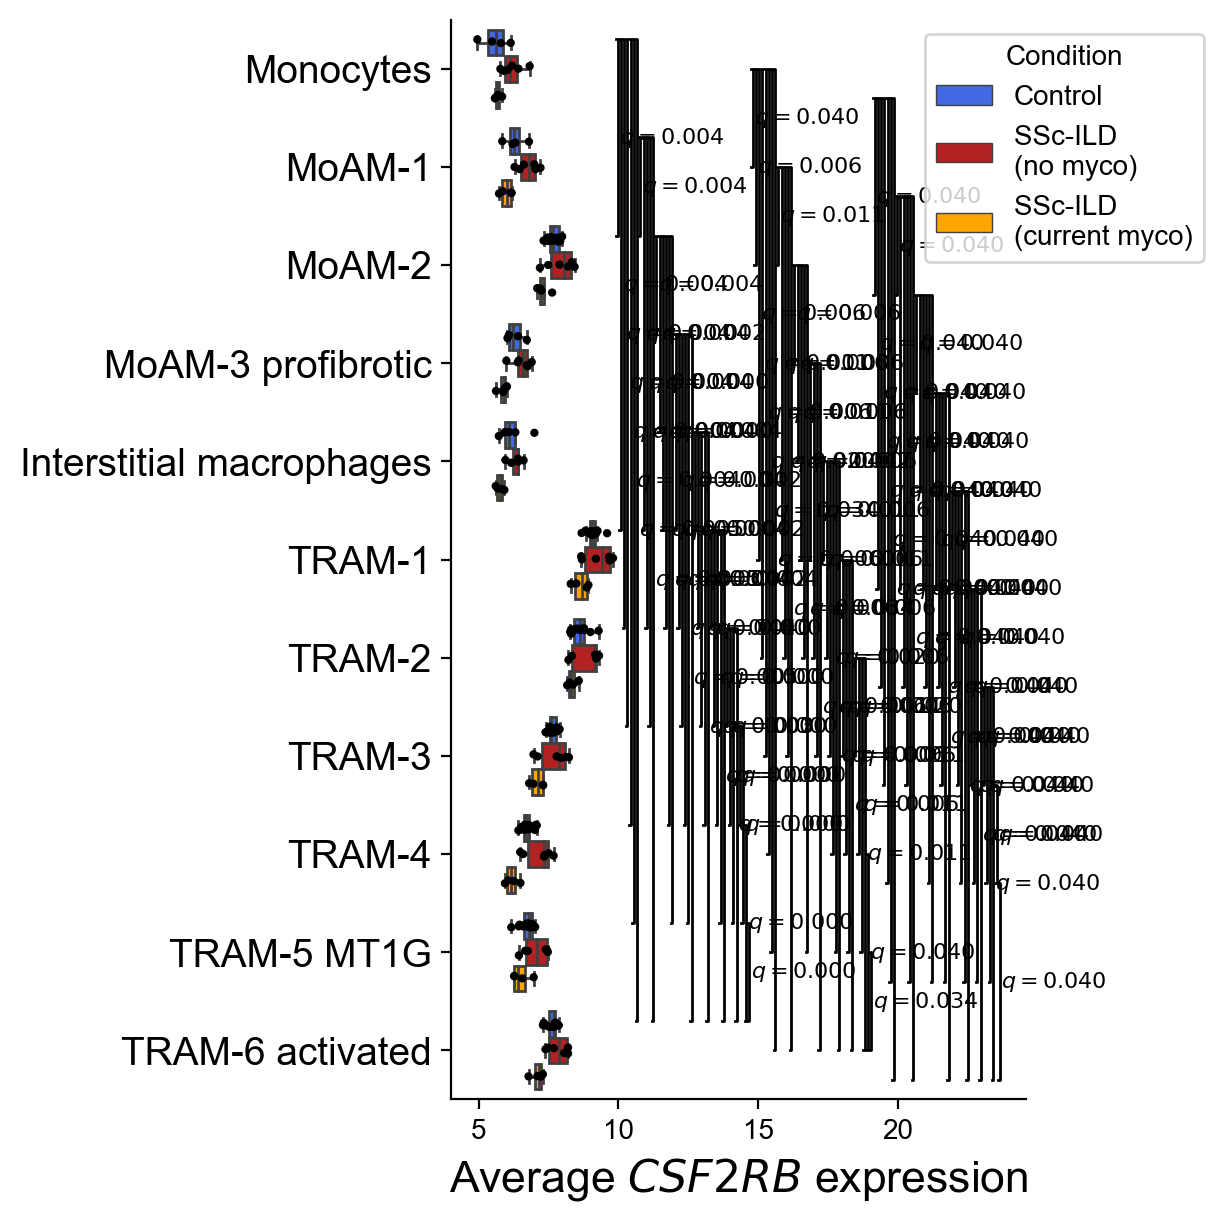

In [61]:
fig, stat_results = plot_gene_with_stats_way2(csf_expr, 'CSF2RB')

In [ ]:
def plot_gene_with_stats_way3(data, gene):
    data_subset = data.loc[data.gene.eq(gene)]
    fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
    sns.boxplot(
        data=data_subset,
        y='cell_type',
        x='expr',
        # hue='exp_group',
        palette=['#999'],
        ax=ax,
        showfliers=False,
        saturation=1,
        linewidth=1
    )
    sns.stripplot(
        data=data_subset,
        y='cell_type',
        x='expr',
        # hue='exp_group',
        # dodge=True,
        ax=ax,
        size=3,
        palette=['k'],
        legend=False
    )
    # exp_groups = list(data_subset.exp_group.cat.categories)
    stat_results = []
    # for group in exp_groups:
    for ct1, ct2 in itertools.combinations(data_subset.cell_type.unique(), 2):
        ct1_data = data_subset.expr[
            data_subset.cell_type.eq(ct1)
        ]
        ct2_data = data_subset.expr[
            data_subset.cell_type.eq(ct2)
        ]
        if ct1_data.size == 0 or ct2_data.size == 0:
            continue
        pval = scipy.stats.mannwhitneyu(ct1_data, ct2_data).pvalue
        stat_results.append(["cell_type", "all", ct1, ct2, ct1_data.size, ct2_data.size, pval])
    stat_results = pd.DataFrame(stat_results, columns=["variable", "value", "group1", "group2",
                                                       "group1_size", "group2_size", "pval"])

    stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]
    stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]

    if stat_results_sign.shape[0] > 0:
        start_height = data_subset.expr.max()
        incrementer = 20 # px
        labels = [x.get_text() for x in ax.get_yticklabels()]
        q = ax.transData.inverted().transform([[0, 0], [incrementer, 0]])
        x_offset = q[1][0] - q[0][0]
        gap = x_offset / 2
        # y = start_height
        x = data_subset.expr.max()
        for _, r in stat_results_sign.iterrows():
            p = f'$q={r.pval_adj:.3f}$'
            y1 = labels.index(str(r.group1))
            y2 = labels.index(str(r.group2))
            if np.abs(y1 - y2) > 1:
                continue
            # x = data_subset.expr[data_subset.cell_type.isin([r.group1, r.group2])].max()
            # group_idx = exp_groups.index(r.value)
            # y1 += 0.3 * (group_idx - 1)
            # y2 += 0.3 * (group_idx - 1)

            col = 'k'
            h = gap / 2
            x += gap

            bracket = ax.plot([x, x+h, x+h, x], [y1, y1, y2, y2], lw=1, c=col)
            txt = ax.text(x+2*h, (y1 + y2) / 2, p, ha='left', va='center', color=col, size=8)

    ax.set_xlabel(f'Average ${gene}$ expression', size=16)
    ax.set_ylabel('')
    ax.tick_params(axis='y', labelsize=14)
    ax.spines[['top', 'right']].set_visible(False)
    # h, l = ax.get_legend_handles_labels()
    # ax.legend(
    #     handles=h,
    #     labels=[l.replace('(', '\n(') for l in exp_groups],
    #     title='Condition',
    #     bbox_to_anchor=(0.8, 1),
    #     loc='upper left'
    # )
    return fig, stat_results

/tmp/ipykernel_63387/3519712277.py:15: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
/tmp/ipykernel_63387/3519712277.py:15: UserWarning: 
The palette list has fewer values (1) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(


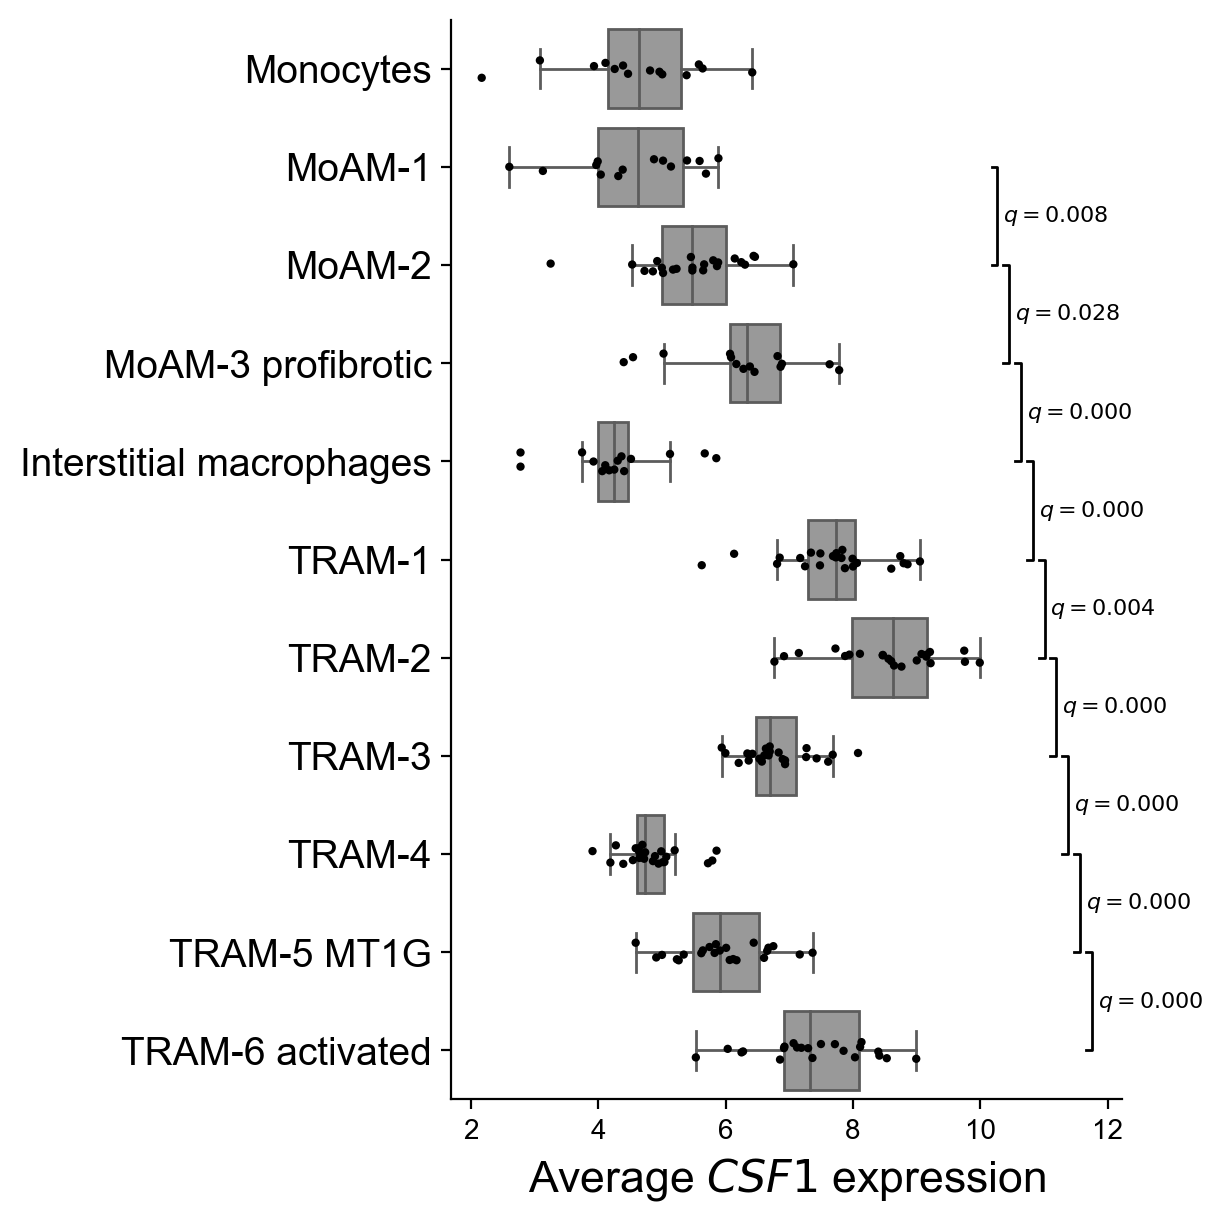

In [52]:
fig, stat_results = plot_gene_with_stats_way3(csf_expr, 'CSF1')

/tmp/ipykernel_63387/3519712277.py:15: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
/tmp/ipykernel_63387/3519712277.py:15: UserWarning: 
The palette list has fewer values (1) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(


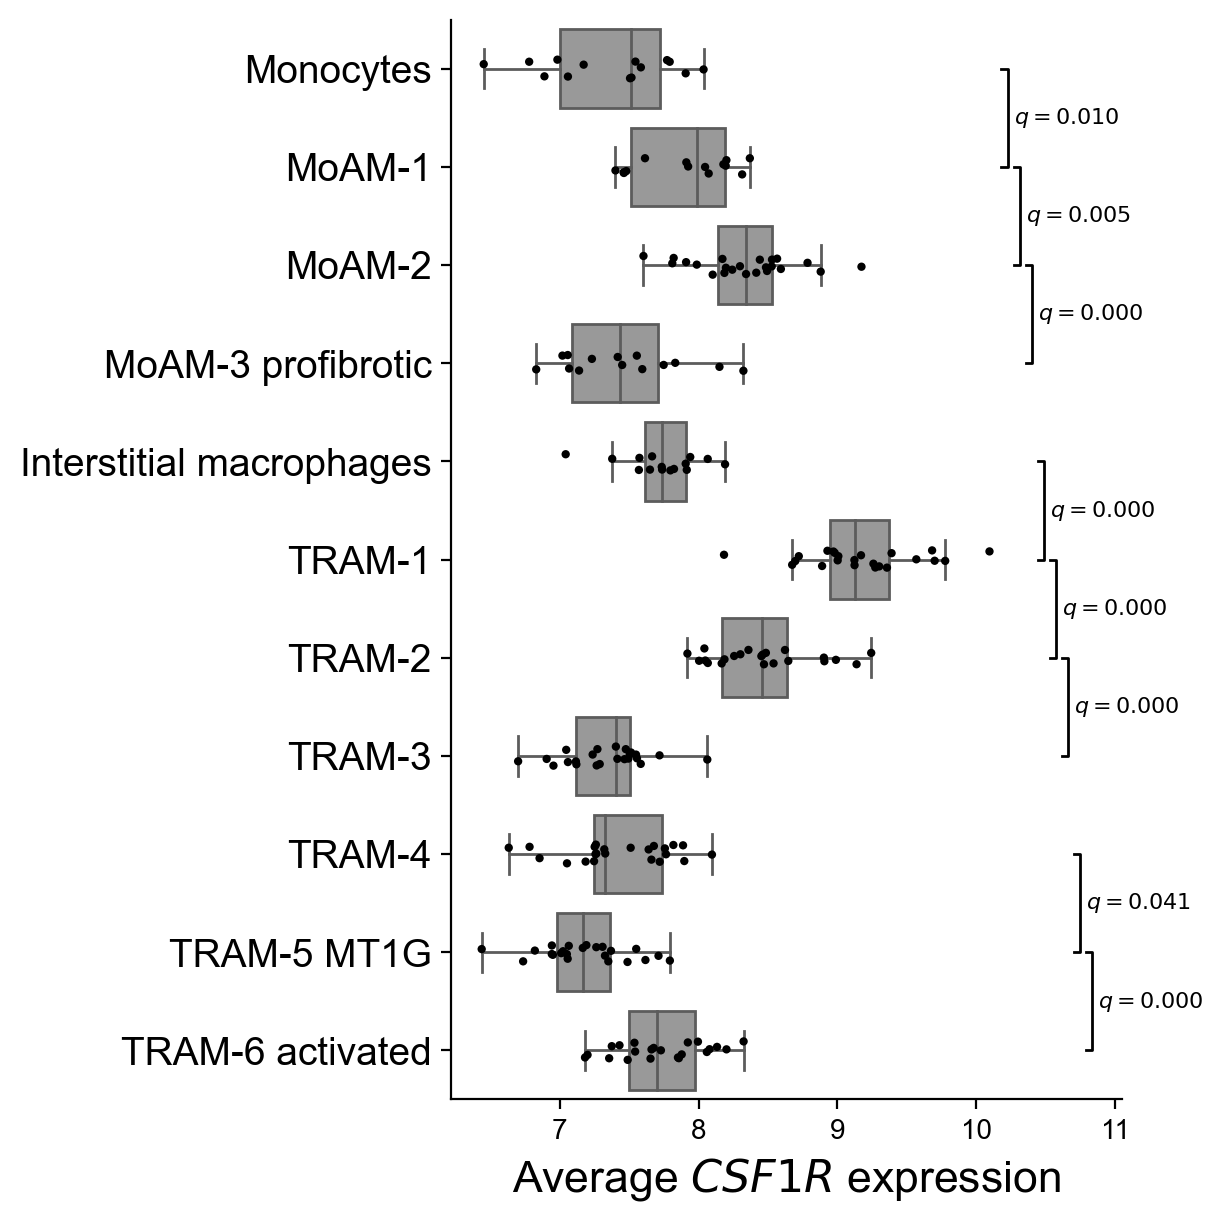

In [53]:
fig, stat_results = plot_gene_with_stats_way3(csf_expr, 'CSF1R')

/tmp/ipykernel_63387/3519712277.py:15: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
/tmp/ipykernel_63387/3519712277.py:15: UserWarning: 
The palette list has fewer values (1) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(


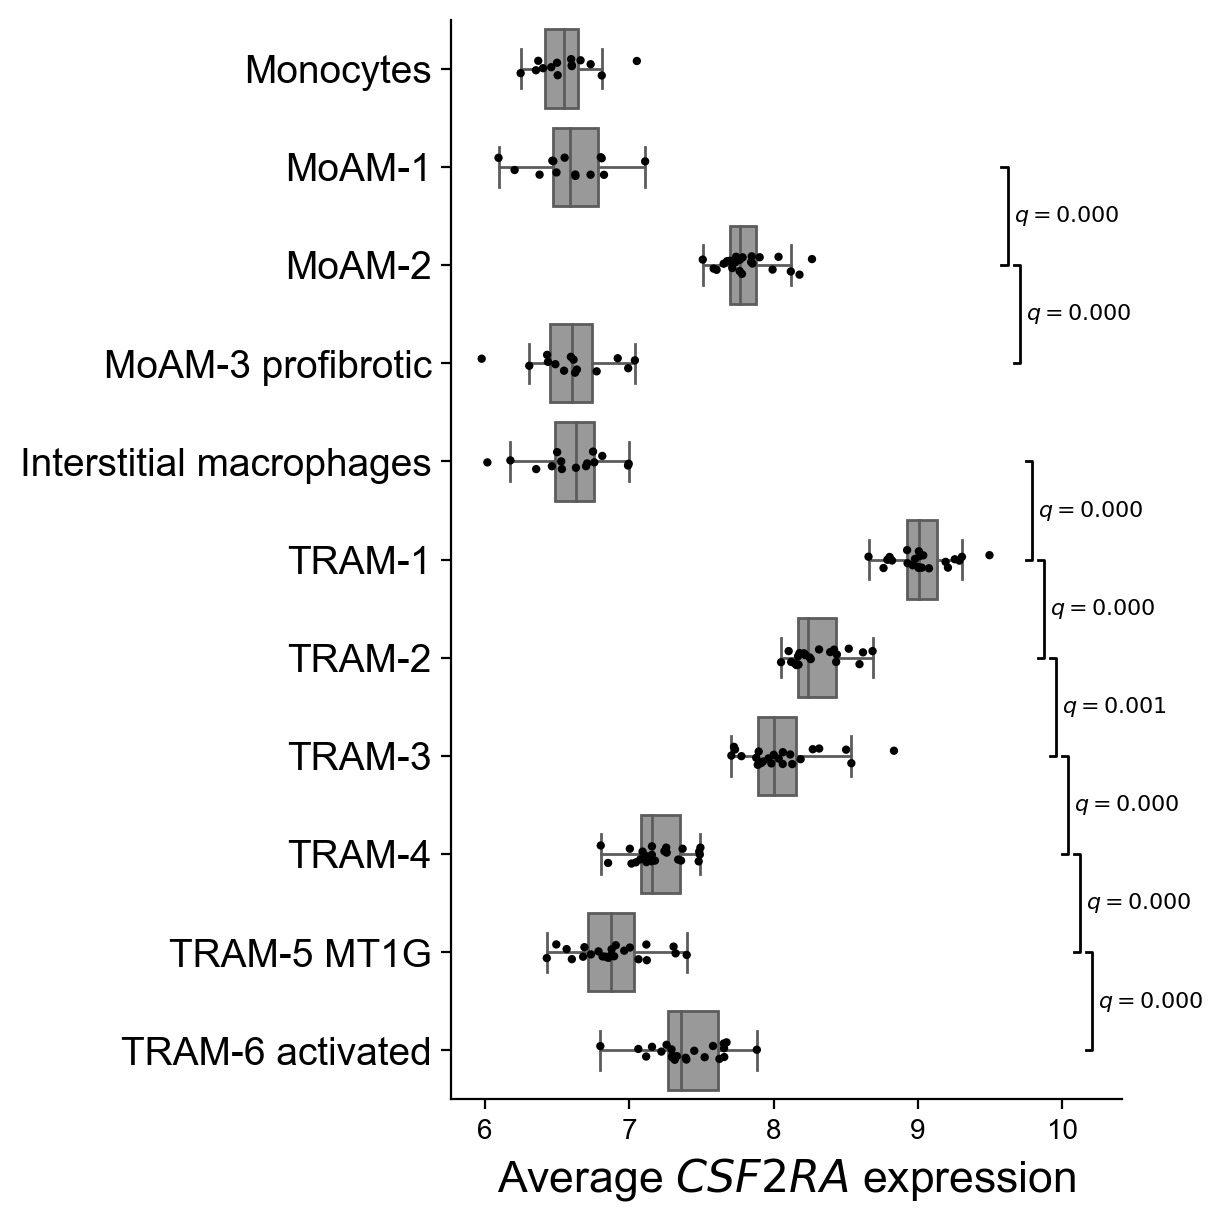

In [54]:
fig, stat_results = plot_gene_with_stats_way3(csf_expr, 'CSF2RA')

/tmp/ipykernel_63387/3519712277.py:15: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
/tmp/ipykernel_63387/3519712277.py:15: UserWarning: 
The palette list has fewer values (1) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(


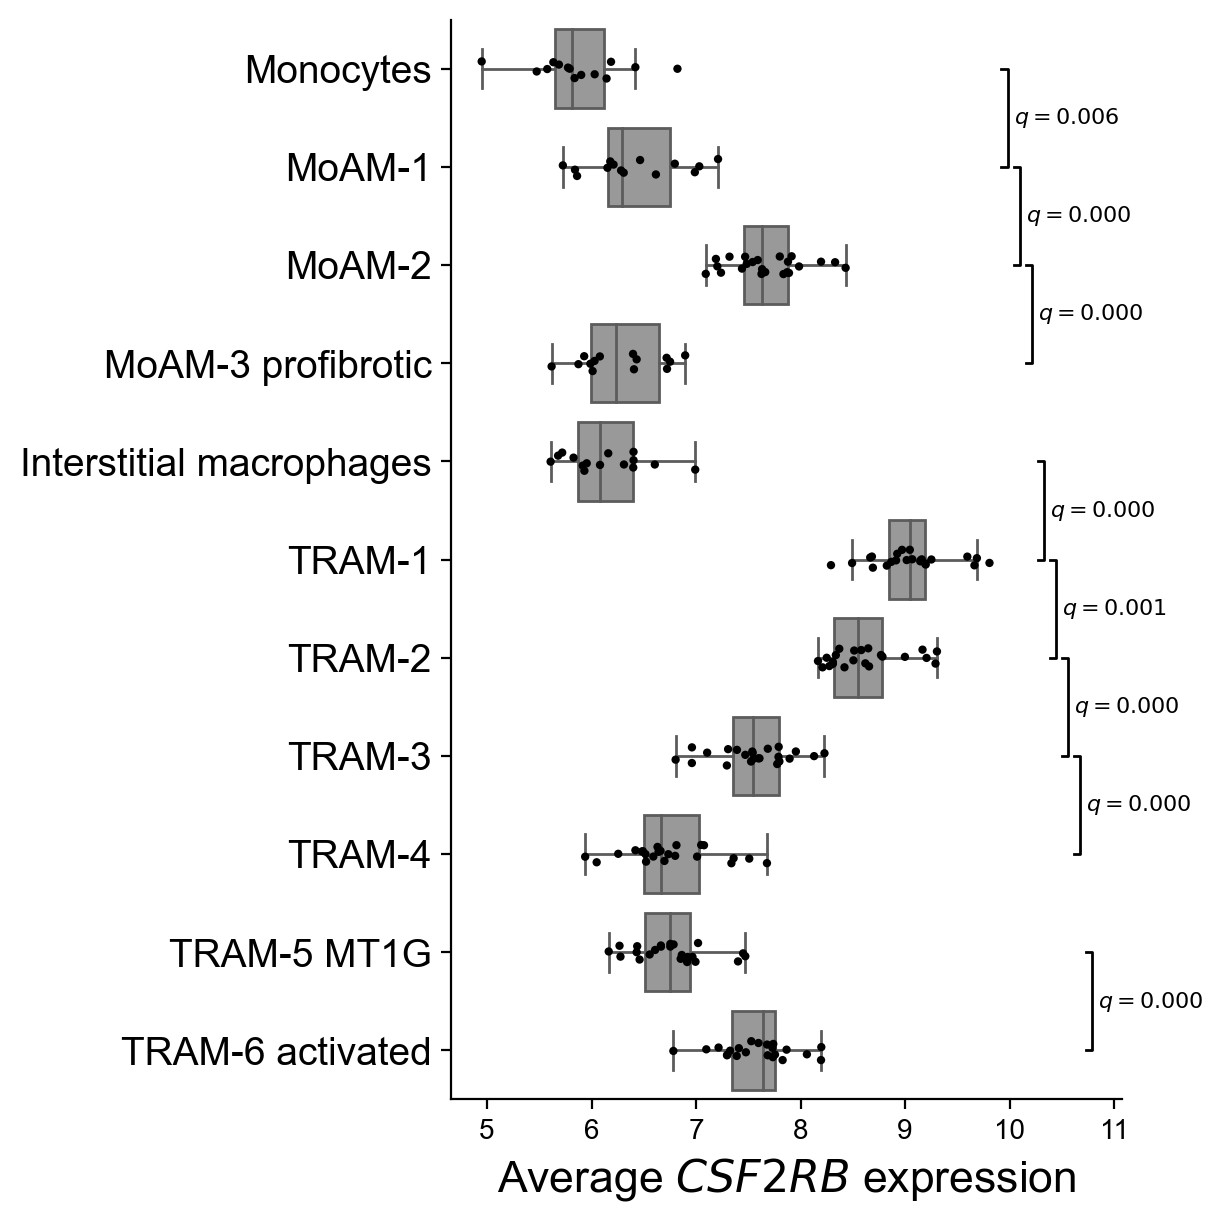

In [55]:
fig, stat_results = plot_gene_with_stats_way3(csf_expr, 'CSF2RB')

## Figure 8A

/tmp/ipykernel_1451890/2073337778.py:13: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
/tmp/ipykernel_1451890/2073337778.py:13: UserWarning: 
The palette list has fewer values (1) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(


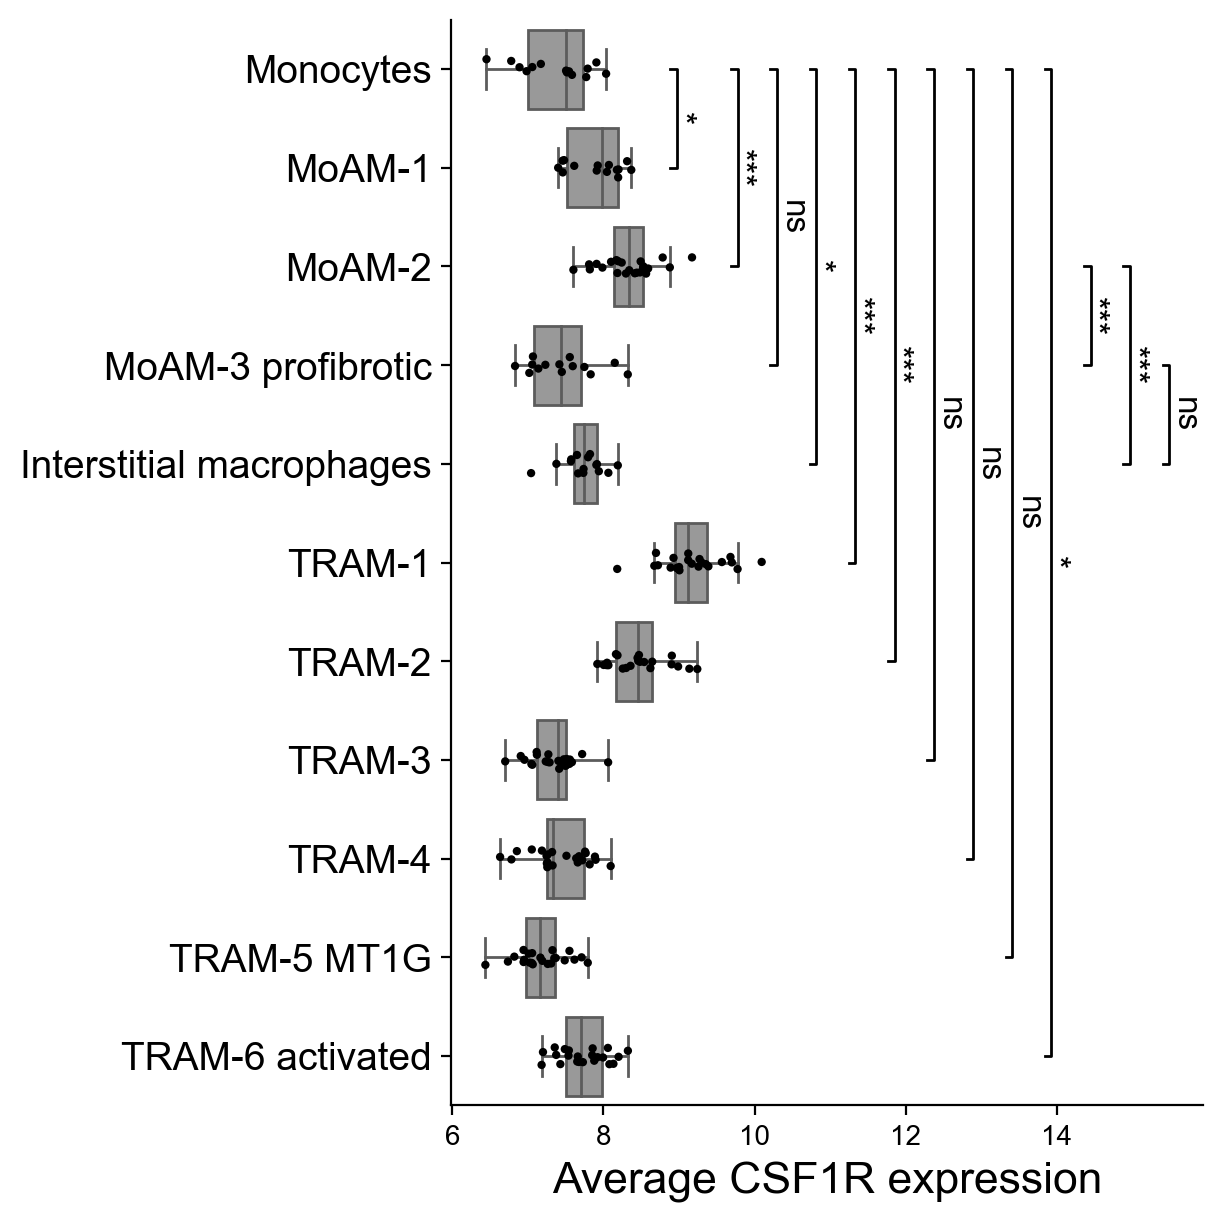

In [ ]:
data_subset = csf_expr.loc[csf_expr.gene.eq('CSF1R')]
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
sns.boxplot(
    data=data_subset,
    y='cell_type',
    x='expr',
    palette=['#999'],
    ax=ax,
    showfliers=False,
    saturation=1,
    linewidth=1
)
sns.stripplot(
    data=data_subset,
    y='cell_type',
    x='expr',
    ax=ax,
    size=3,
    palette=['k'],
    legend=False
)

stat_results = []

comparisons = [
    ('Monocytes', x) for x in data_subset.cell_type.unique() if x != 'Monocytes'
]
comparisons += [
    ('MoAM-2', 'MoAM-3 profibrotic'),
    ('MoAM-2', 'Interstitial macrophages'),
    ('MoAM-3 profibrotic', 'Interstitial macrophages'),
]

for ct1, ct2 in comparisons:
    ct1_data = data_subset.expr[
        data_subset.cell_type.eq(ct1)
    ]
    ct2_data = data_subset.expr[
        data_subset.cell_type.eq(ct2)
    ]
    if ct1_data.size == 0 or ct2_data.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(ct1_data, ct2_data).pvalue
    stat_results.append(["cell_type", "all", ct1, ct2, ct1_data.size, ct2_data.size, pval])
stat_results = pd.DataFrame(stat_results, columns=["variable", "value", "group1", "group2",
                                                    "group1_size", "group2_size", "pval"])

stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]

if stat_results.shape[0] > 0:
    start_height = data_subset.expr.max()
    incrementer = 40 # px
    labels = [x.get_text() for x in ax.get_yticklabels()]
    q = ax.transData.inverted().transform([[0, 0], [incrementer, 0]])
    x_offset = q[1][0] - q[0][0]
    gap = x_offset / 2
    # y = start_height
    # dict to hold x positions for each cell type
    x = data_subset.groupby('cell_type').expr.max().to_dict()
    for _, r in stat_results.iterrows():
        if r.pval_adj >= 0.05:
            p = 'ns'
        elif r.pval_adj > 0.01:
            p = '*'
        elif r.pval_adj > 0.001:
            p = '**'
        else:
            p = '***'

        y1 = labels.index(str(r.group1))
        y2 = labels.index(str(r.group2))

        # check group1, group2 and all groups in between to determine maximum x position
        # we assume group1 is always less than group2
        x_data = x[r.group1]
        for y_idx in range(y1 + 1, y2 + 1):
            y_group = labels[y_idx]
            if x_data < x[y_group]:
                x_data = x[y_group]

        x_data += gap * 3
        for y_idx in range(y1, y2 + 1):
            y_group = labels[y_idx]
            x[y_group] = x_data

        col = 'k'
        h = gap / 2

        bracket = ax.plot([x_data, x_data+h, x_data+h, x_data], [y1, y1, y2, y2], lw=1, c=col)
        if p == 'ns':
            text_x = x_data + h
        else:
            text_x = x_data - h
        txt = ax.text(text_x, (y1 + y2) / 2, p, ha='left', va='center', color=col, size=12, rotation=270)

ax.set_xlabel(f'Average CSF1R expression', size=16)
ax.set_ylabel('')
ax.tick_params(axis='y', labelsize=14)
ax.spines[['top', 'right']].set_visible(False)
fig.savefig('00_figures/Figure_8A_CSF1R_expr.pdf')
